# Building Training Sets with Weak Supervision
In this tutorial, we'll build a `Pain-Anatomy` relation training set using weakly superivsed methods. This notebook covers: 
- Loading pre-processed documents
- Generating relational candidates 
- Applying labeling functions
- Training a Snorkel Label Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,'../../ehr-rwe/')

import glob
import collections
import numpy as np
import pandas as pd

In [2]:
import snorkel

print(f'Python version {sys.version}')
print(f'Snorkel v{snorkel.__version__}')
print(f'NumPy v{np.__version__}')

Python version 3.6.7 | packaged by conda-forge | (default, Nov  6 2019, 16:03:31) 
[GCC Clang 9.0.0 (tags/RELEASE_900/final)]
Snorkel v0.9.4+dev
NumPy v1.18.1


## 1. Load MIMIC-III Documents

This notebook assumes documents have already been preprocessed and dumped into JSON format, and placed in the `../data/` subdirectory. We created a small annotated dataset using MIMIC-III patient notes, and provide the relevant row IDs for those notes in `../data/annotations/`. See the `mimic_to_tsv.py` and `preprocess.py` scripts in `preprocessing/` to create the required JSON files.

You will need access to MIMIC-III data to run this notebook using our tutorial annotations.  See https://mimic.physionet.org/gettingstarted/access/

See `preprocessing/README.md` for details.

In [3]:
from rwe import dataloader

inputdir = '../data/corpora/'
 
corpus = [
    dataloader([f'{inputdir}/mimic_gold.0.json']), 
    dataloader([f'{inputdir}/mimic_unlabeled.0.json'])
]

for split in corpus:
    print(f'Loaded {len(split)} documents')


Loaded 55 documents
Loaded 1322 documents


## 2. Generate Candidates

This is an example pipeline for generating `Pain-Anat` relation candidates. Relations are defined as a tuple $k$ entity spans. For simplicity's sake, we consider binary relations between all `Anatomy` and `Pain` entity pairs found within the same sentence. Entities can be tagged using a clinical named entity recognition (NER) model if available. Here we use a dictionary-based method to tag our initial `Anatomy` and `Pain` entities. 

### Clinical Text Markup
When writing labeling functions, it's helpful to have access to document markup and other metadata. For example, we might want to know what document section we are currently in (e.g., Past Medical History) or if we have temporal information above an event, such as a data of occurence, we might want to incorporate that information into our labeling heuristics. 

We have written taggers that identify these document attributes, and execute them below in the same pipeline that extracts our `Pain-Anat` relation candidates.

### Timing Benchmarks 

- 4 core MacBook Pro 2.5Ghz mid-2015

| N Documents   | N Cores | Time |
|---------------|---------|----------------|
| 1322          | 4       | 1 minute 10 secs |



In [4]:
from rwe.utils import load_dict
from rwe.labelers.taggers import (
    ResetTags, RelationTagger, 
    DictionaryTagger, NegExTagger, HypotheticalTagger, HistoricalTagger,
    SectionHeaderTagger, ParentSectionTagger,
    DocTimeTagger, MappedDocTimeTagger, 
    Timex3Tagger, Timex3NormalizerTagger, TimeDeltaTagger,
)

dict_pain = load_dict('../data/supervision/dicts/pain/pain.txt')
dict_anat = load_dict('../data/supervision/dicts/anatomy/fma_anatomy.bz2')

target_entities = ['pain']

# NOTE: Pipelines are *order dependant* as normalizers and attribute taggers assume
# the existence of certain concept targets (e.g., Timex3Normalizer requires timex3 entities)
pipeline = {
    # 1. Clear any previous runs
    "reset"        : ResetTags(),
    
    # 2. Clinical concepts
    "concepts"  : DictionaryTagger({'pain': dict_pain, 'anatomy': dict_anat}),
    "headers"   : SectionHeaderTagger(),
    "timex3"    : Timex3Tagger(),
    
    # 3. Normalize datetimes
    "doctimes"  : DocTimeTagger(prop='CHARTDATE'), # document time stamp
    "normalize" : Timex3NormalizerTagger(),
    
    # 4. Concept attributes
    "section"      : ParentSectionTagger(targets=target_entities),
    "tdelta"       : TimeDeltaTagger(targets=target_entities),
    "negation"     : NegExTagger(targets=target_entities, data_root="../data/supervision/dicts/negex/"),
    "hypothetical" : HypotheticalTagger(targets=target_entities),
    'historical'   : HistoricalTagger(targets=target_entities),
    
    # 5. Extract relation candidates
    "pain-anat"    : RelationTagger('pain-anatomy', ('pain', 'anatomy'))
}


In [5]:
%%time
from rwe.labelers import TaggerPipelineServer

tagger = TaggerPipelineServer(num_workers=4)
documents = tagger.apply(pipeline, corpus)


auto block size=345
Partitioned into 4 blocks, [342 345] sizes
CPU times: user 2.42 s, sys: 424 ms, total: 2.84 s
Wall time: 1min 7s


In [6]:
from rwe.utils import build_candidate_set

Xs = [
    build_candidate_set(documents[0], "pain-anatomy"),
    build_candidate_set(documents[1], "pain-anatomy")
]

# Split: 0 n_candidates: 390
# Split: 1 n_candidates: 5185
for i in range(len(Xs)):
    print(f'Split: {i} n_candidates: {len(Xs[i])}')

Split: 0 n_candidates: 390
Split: 1 n_candidates: 5185


### Load Gold Labeled Data
As a source of gold labeled data for evaluating our relation extraction model, we have annotated MIMIC III notes to identify pain-anatomy relations, using Brat. We have provided the Brat annotation files as part of this demo.

In [7]:
from rwe.contrib.brat import *

inputdir = "../data/brat/"

gold = BratAnnotations(inputdir)
gold.annotator_summary()
gold.annotator_agreement(ignore_types=['Concept'], relations_only=True)

ANNOTATOR SUMMARY
-------------------------
annotator_b
-------------------------
ENTITY              962
 - Concept          962
                         
RELATION            177
 - X-at             177
                         
-------------------------
annotator_a
-------------------------
ENTITY              961
 - Concept          961
                         
RELATION            174
 - X-at             174
                         
Kappa Agreement (method=randolph)
OVERALL        (n=524): 0.950
X-at           (n=179): 0.922


#### We are only considering `pain-anat` relations for this tutorial, so let's filter the gold data to only pain mentions.

In [8]:
annos = gold.aggregate_raters(ignore_types=['Concept'], relations_only=True)

Ys_brat = {}
relations = [x for x in annos if x.type == 'X-at']
for x in relations:
    # only include gold relations for pain-anat
    args = [a.text.lower() for a in x.args]
    if dict_pain.intersection(args):   
        # create unique key DOC_NAME, SPANS
        key = tuple([x.doc_name] + sorted([ety.span for ety in x.args]))
        Ys_brat[key] = x
        
print(len(Ys_brat))


154


Now we'll build our target labels `Ys` mapping to whether each relation is a a true present positive occurance of pain or not.

In [9]:
debug = {}

Ys = []
for x in Xs[0]:
    spans = [
        ((x.pain.abs_char_start, x.pain.abs_char_end + 1),),
        ((x.anatomy.abs_char_start, x.anatomy.abs_char_end + 1),)
    ]
    key = tuple([x.pain.sentence.document.name] + sorted(spans))
    y = 1 if key in Ys_brat else 2
    Ys.append(y)
    
    if key in Ys_brat:
        debug[key] = x
    
print(Ys.count(1)) 
print(Ys.count(2))

142
248


### Missing Candidates
When using a simple dictionary-based method to enumerate candidate relations, we typically have some subset of true mentions that we fail to generate. In this case, we are missing anatomical entities such as "bilateral flank" and "midback", which are not in our UMLS-based anatomy dictionary. These missing candidates impact our final recall score.

In [10]:
n_missing = 0
for key in Ys_brat:
    if key not in debug:
        print(Ys_brat[key])
        n_missing += 1
        
print(f'Missed {n_missing} ({n_missing / len(Ys_brat) * 100:2.1f}%) of true relations')

X-at( Concept("pain":277-281), Concept("midback":295-302) )
X-at( Concept("left jaw":534-542), Concept("pain":551-555) )
X-at( Concept("bilateral flank":680-695), Concept("pain":696-700) )
X-at( Concept("bilateral flank":7082-7097), Concept("pain":7098-7102) )
X-at( Concept("low back":1529-1537), Concept("pain":1538-1542) )
X-at( Concept("lower back":1272-1277), Concept("pain":1283-1287) )
X-at( Concept("Pain":871-875), Concept("R scapula":920-929) )
X-at( Concept("facial":268-274), Concept("numbness":275-283) )
X-at( Concept("left shoulder":4144-4148), Concept("pain":4158-4162) )
X-at( Concept("tender":1415-1421), Concept("R trochantor":1422-1434) )
X-at( Concept("sternal":286-293), Concept("pain":305-309) )
X-at( Concept("cervical":405-413), Concept("pain":433-437) )
Missed 12 (7.8%) of true relations


## 3. Apply Labeling Functions

Below is a set of example labeling functions that use document attributes and sentence content to vote on whether a given `pain-anat` relation candidate is a true mention.

In [121]:
import re
from rwe.helpers import get_left_span, get_right_span, get_between_span, token_distance

def dict_matches(span, dictionary):
    matches = []
    toks = span.get_attrib_tokens('words')
    for i in range(len(toks)):
        for j in range(i+1, len(toks)):
            term = ' '.join(toks[i:j]).lower()
            if term in dictionary:
                matches.append(term)
    return matches

ABSTAIN  = 0
NEGATIVE = 2
POSITIVE = 1

neg_rgx = re.compile(
    r'''\b(insensitivity|paresthesias|paresthesia|sensitivity|tenderness|discomfort|heaviness|sensitive|itchiness|tightness|throbbing|numbness|tingling|cramping|coldness|soreness|painful|hurting|itching|burning|tender|buring|aching|hurts|aches|pains|hurt|pain|ache|achy|numb)\b''',
    re.I
)

def LF_is_negated(x):
    return NEGATIVE if 'negated' in x.pain.props else ABSTAIN

def LF_is_hypothetical(x):
    return NEGATIVE if 'hypothetical' in x.pain.props else ABSTAIN

def LF_is_historical(x):
    if 'hist' not in x.pain.props:
        return ABSTAIN
    return NEGATIVE if x.pain.props['hist'] == 1 else POSITIVE

def LF_section_headers(x):
    """Predict label based on the section this candidate relation is found in."""
    sections = {
        'past medical history': NEGATIVE,
        'chief complaint': POSITIVE,
        'discharge instructions': NEGATIVE,
        'discharge condition': NEGATIVE,
        'active issues':POSITIVE,
        'brief hospital course':NEGATIVE,
    }
    header = x.pain.props['section'].text.lower() if x.pain.props['section'] else None
    return ABSTAIN if header not in sections else sections[header]

def LF_contiguous_args(x):
    """Candidate is of the form 'chest pain'"""
    v = not get_between_span(x.pain, x.anatomy)
    v &= not 'negated' in x.pain.props
    v &= not 'hypothetical' in x.pain.props
    v &= not ('hist' in x.pain.props and x.pain.props['hist'] == 1)
    v &= not ('tdelta' in x.pain.props and x.pain.props['tdelta'] < -1)
    return POSITIVE if v else ABSTAIN

def LF_distant_args(x, max_toks=10):
    """Reject candidate if the arguments occur too far apart (in token distance)."""
    span = get_between_span(x.pain, x.anatomy)
    n_toks = len(span.get_attrib_tokens('words')) if span else 0
    return NEGATIVE if n_toks > max_toks else ABSTAIN
    
def LF_between_terms(x):
    """Reject if some key terms occur between arguments."""
    span = get_between_span(x.pain, x.anatomy)
    if not span:
        return ABSTAIN
    # negation term      
    flag = neg_rgx.search(span.text) is not None
    # anatomical term 
    flag |= len(dict_matches(span, dict_anat)) > 0
    return NEGATIVE if flag else ABSTAIN

def LF_complains_of(x):
    """Search for pattern 'complains of X' """
    rgx = re.compile(r'''\b(complain(s*|ing*) of)\b''', re.I)
    is_negated = 'negated' in x.pain.props
    is_complains_of = rgx.search(get_left_span(x.pain).text) is not None
    return POSITIVE if not is_negated and is_complains_of else ABSTAIN

def LF_denies(x):
    """Patient denies X"""
    rgx = re.compile(r'''\b(denied|denies|deny)\b''', re.I)
    is_denies = rgx.search(get_left_span(x.pain).text) is not None
    return NEGATIVE if is_denies else ABSTAIN

def LF_non(x):
    """non-tender"""
    rgx = re.compile(r'''(non)[-]*''', re.I)
    is_negated = rgx.search(get_left_span(x.pain, window=2).text) is not None
    return NEGATIVE if is_negated else ABSTAIN

def LF_if(x):
    rgx = re.compile(r'''^if you\b''', re.I)
    is_hypo = rgx.search(get_left_span(x.pain).text) is not None
    return NEGATIVE if is_hypo else ABSTAIN    

def LF_tdelta(x):
    if 'tdelta' not in x.pain.props:
        return ABSTAIN
    #tok_dist = token_distance(x.pain, x.pain.props['timex_span'])
    return NEGATIVE if x.pain.props['tdelta'] < -1 else ABSTAIN

def LF_pseudo_negation(x):
    rgx = re.compile(r'''\b(no (change|improvement|difference))\b''', re.I)
    is_negated = rgx.search(get_left_span(x.pain).text) is not None
    return POSITIVE if is_negated else ABSTAIN
    

lfs = [
    LF_is_negated,
    LF_is_hypothetical,
    LF_is_historical,
    LF_section_headers,
    LF_contiguous_args,
    LF_distant_args,
    LF_between_terms,
    LF_complains_of,
    LF_denies,
    LF_non,
    LF_if,
    LF_tdelta,
    LF_pseudo_negation
]


Let's apply these LFs to our training data.

In [122]:
%%time
from rwe.labelers import LabelingServer

labeler = LabelingServer(num_workers=4)
Ls = labeler.apply(lfs, Xs)


CPU times: user 1.15 s, sys: 295 ms, total: 1.45 s
Wall time: 4.16 s


We can then examine the accuracy of each of our LFs using the gold labeled data as ground truth.

In [123]:
from rwe.analysis import lf_summary

lf_summary(Ls[0], Y=Ys, lf_names=[lf.__name__ for lf in lfs])


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_is_negated,0,2,0.156410,0.089744,0.007692,57,4,0.934426
LF_is_hypothetical,1,2,0.012821,0.012821,0.000000,5,0,1.000000
LF_is_historical,2,"[1, 2]",0.253846,0.223077,0.023077,80,19,0.808081
LF_section_headers,3,"[1, 2]",0.348718,0.310256,0.082051,116,20,0.852941
LF_contiguous_args,4,1,0.387179,0.220513,0.084615,117,34,0.774834
LF_distant_args,5,2,0.156410,0.143590,0.000000,61,0,1.000000
LF_between_terms,6,2,0.156410,0.128205,0.010256,61,0,1.000000
LF_complains_of,7,1,0.023077,0.023077,0.010256,6,3,0.666667
LF_denies,8,2,0.053846,0.048718,0.020513,21,0,1.000000
LF_non,9,2,0.028205,0.012821,0.000000,11,0,1.000000


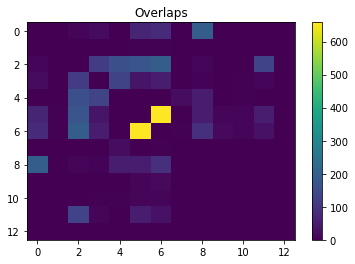

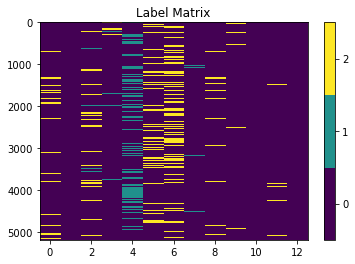

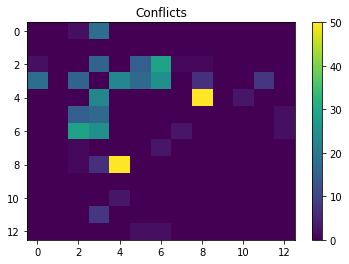

In [124]:
from rwe.visualization.analysis import view_conflicts, view_label_matrix, view_overlaps

view_overlaps(Ls[1], normalize=False)
view_label_matrix(Ls[1])
view_conflicts(Ls[1], normalize=False)

## 4. Train Snorkel Label Model 

### The next step is to train a Snorkel Label model using the data labeled with our labeling functions.

In [125]:
# convert sparse matrix to new Snorkel format

def convert_label_matrix(L):
    L = L.toarray().copy()
    L[L == 0] = -1
    L[L == 2] = 0
    return L


Ls_hat = [
    convert_label_matrix(Ls[0]),
    convert_label_matrix(Ls[1]),
]

Ys_hat = [
    np.array([0 if y == 2 else 1 for y in Ys]),
    []
]


In [126]:
from snorkel.labeling.model import LabelModel
lr = 0.01
l2 = 0.01
prec_init = 0.7

label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=Ls_hat[1], 
                n_epochs=100, 
                lr=lr,
                l2=l2,
                prec_init=prec_init,
                optimizer='adam',
                log_freq=100)

metrics = ['accuracy', 'precision', 'recall', 'f1']
label_model.score(L=Ls_hat[0], Y=Ys_hat[0], metrics=metrics)


{'accuracy': 0.8352272727272727,
 'precision': 0.718562874251497,
 'recall': 0.916030534351145,
 'f1': 0.8053691275167785}

## 5. Predict Probabalsitic Labels for Unlabeled Data

### The last step in this tutorial is to use our labeling model to predict on new data.

In [127]:
Y_proba = label_model.predict_proba(Ls_hat[0])

In [128]:
Y_pred = label_model.predict(Ls_hat[0])

## Error Analysis
This replicates the metrics generated above

In [129]:
from sklearn.metrics import precision_score, recall_score, f1_score

def apply_lfs(x, lfs):
    V = []
    for lf in lfs:
        v = lf(x)
        if v != 0:
            V.append((v, lf.__name__))
            
    return list(zip(*V)) if V else None,None
        
errs = {}
y_gold, y_pred = [],[]
for i,(x, y_hat) in enumerate(zip(Xs[0], Y_pred)):
    # skip uncovered points 
    # NOTE: there is currently a bug in the Snorkel label model
    if y_hat == -1:
        continue
        
    y_hat = 2 if y_hat == 0 else 1
    y_gold.append(Ys[i])
    y_pred.append(y_hat)
    if y_hat != Ys[i]:
        errs[x] = (Ys[i], y_hat, Y_proba[i])
    
    
p = precision_score(y_gold, y_pred)
r = recall_score(y_gold, y_pred)
f1 = f1_score(y_gold, y_pred)

In [130]:
print(p, r, f1)

0.718562874251497 0.916030534351145 0.8053691275167785


In [131]:
for x in errs:
    y, y_hat, y_proba = errs[x]
    v, fired_lfs = apply_lfs(x,lfs)
    print(x)
    print('DOCTIME', x.pain.sentence.document.props['doctime'])
    print([x.pain.sentence.text])
    print(x.pain.props)
    print(v)
    print(y, y_hat, y_proba)
    print('=' * 40)

Relation[pain-anatomy](Span(pain),Span(right hip))
DOCTIME 2009-05-20 00:00:00
['and hx of hip replacement presenting with right hip pain.']
{'section': Span(History of Present Illness), 'hist': 1}
[(2,), ('LF_is_historical',)]
1 2 [0.79402977 0.20597023]
Relation[pain-anatomy](Span(pain),Span(abd))
DOCTIME 2009-05-20 00:00:00
['No fever/chest pain/SOB/abd pain/new focal neurologic changes.']
{'section': Span(History of Present Illness)}
[(1,), ('LF_contiguous_args',)]
2 1 [0.06255685 0.93744315]
Relation[pain-anatomy](Span(tender),Span(bowel))
DOCTIME 2009-05-20 00:00:00
['Abdomen: soft, non-tender, non-distended, bowel sounds present, no rebound tenderness or guarding, no organomegaly']
{'section': Span(Abdomen)}
[(2,), ('LF_non',)]
2 1 [0.49449418 0.50550582]
Relation[pain-anatomy](Span(tender),Span(Abdomen))
DOCTIME 2009-05-20 00:00:00
['Abdomen: soft, non-tender, non-distended, bowel sounds present, no rebound tenderness or guarding, no organomegaly']
{'section': Span(Abdomen)}
[(